<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/object_detectionAPI/flap_bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
# Clone the tensorflow models repository if it doesn't already exist
import pathlib

if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2444, done.
remote: Counting objects: 100% (2444/2444), done.
remote: Compressing objects: 100% (2047/2047), done.
remote: Total 2444 (delta 582), reused 1382 (delta 369), pack-reused 0
Receiving objects: 100% (2444/2444), 30.85 MiB | 38.05 MiB/s, done.
Resolving deltas: 100% (582/582), done.


In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624271 sha256=fc414d12896adb5ea4e7c53d078712c178040fbf7bcce56f0b853023d22b24a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-31hqhkam/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp37-none-any.whl size=43735 sha256=70343e013871fea66a85f3cbfead3327980ca03534a10b41c6e4b3b22b173680
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=9dafde80430d60daa178dbf6e2732523e6f32e10c2a29f48dbe1934a64315b69
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=bc3623ca9c4a73e2cfd95e37535ead212898941edf7619025704

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [3]:
# import utils from the Object Detection API
#import libraries
import os
import random

import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from six import BytesIO

import tensorflow as tf
from google_drive_downloader import GoogleDriveDownloader

from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
# more utility function
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize = (12, 16),
                    image_name = None):
    
    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh = 0.5)
    
    plt.imshow(image_np_with_annotations)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

# Prepare Images

In [5]:
# download data
GoogleDriveDownloader.download_file_from_google_drive(file_id = "1QgK9of9XFLCi_1_GA_1ejz5Uwrp95lsd",
                                                      dest_path = "./flap_bird.zip",
                                                      unzip = True)

Unzipping...Done.


Total images: 4


<Figure size 432x288 with 0 Axes>

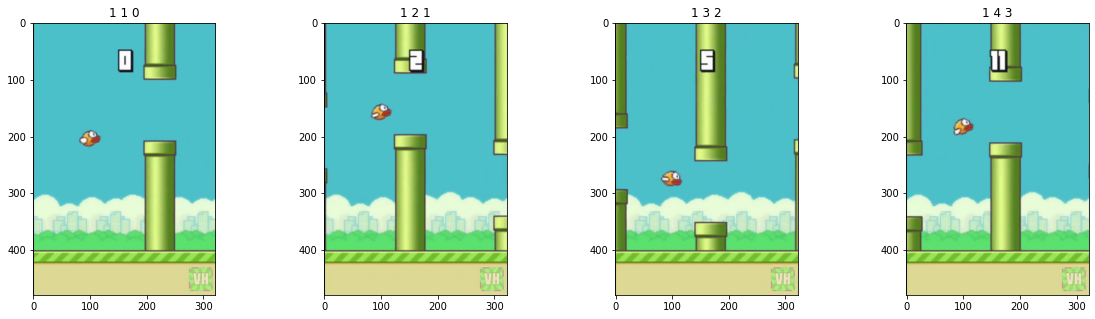

<Figure size 1440x360 with 0 Axes>

In [6]:
# Load images and visualize
n_col = 4 # number of columns in image grid
train_images_np = []
train_image_dir = "/content/train"

for dir, fol, files in os.walk(train_image_dir):
    files.sort()
    total_images = len(files)
    print("Total images: {}".format(total_images))

    for image in files:
        image_path = os.path.join(train_image_dir, image)
        try:
            train_images_np.append(load_image_into_numpy_array(image_path))
        except:
            !rm "/content/train/.ipynb_checkpoints"

n_row = total_images // n_col + 1

plt.tight_layout() 
for row in range(n_row):
    fig = plt.figure(figsize = (5 * n_col, 5))
    for column in range(n_col):
        if row * n_col + column == total_images:
            break
        fig.add_subplot(1, n_col, column + 1)
        plt.title("{} {} {}".format(row + 1, column + 1, row * n_col + column))
        plt.imshow(train_images_np[row * n_col + column])
    plt.show()


In [7]:
# make your own object boxes
passaro_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer = passaro_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [8]:
# make your own object boxes
buraco_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer = buraco_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [9]:
passaro_boxes = np.asarray(passaro_boxes)
buraco_boxes = np.asarray(buraco_boxes)

In [10]:
gt_boxes = np.concatenate((passaro_boxes,buraco_boxes), axis = 1)

In [11]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
num_classes = 2
passaro_class_id = 1
buraco_class_id = 2

category_index = {passaro_class_id: {"id": passaro_class_id, "name": "passarinho"},
                  buraco_class_id: {"id": buraco_class_id, "name": "buraco"}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):

    train_image_tensors.append(
        tf.expand_dims(
            tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))

    gt_box_tensors.append(
        tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.asarray([passaro_class_id, buraco_class_id]) - label_id_offset)

    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
    
print('Done prepping data.')

Done prepping data.


<Figure size 432x288 with 0 Axes>

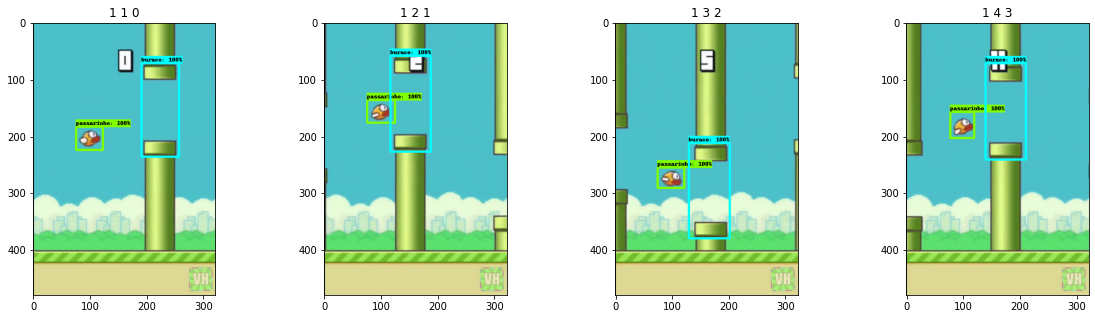

<Figure size 1440x360 with 0 Axes>

In [12]:
dummy_scores = np.array([1.0, 1.0], dtype=np.float32)  # give boxes a score of 100%

plt.tight_layout() 
for row in range(n_row):
    fig = plt.figure(figsize = (5 * n_col, 5))
    for column in range(n_col):
        if row * n_col + column == total_images:
            break
        fig.add_subplot(1, n_col, column + 1)
        plt.title("{} {} {}".format(row + 1, column + 1, row * n_col + column))
        plot_detections(
            train_images_np[row * n_col + column],
            gt_boxes[row * n_col + column],
            [1,2],
            dummy_scores, category_index)
    plt.show()


In [13]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-03-02 02:47:13--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.80, 2607:f8b0:4004:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  56.8MB/s    in 4.1s    

2021-03-02 02:47:17 (56.8 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [14]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush = True)
num_classes = 2
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training = True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [15]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 10
learning_rate = 0.005
num_batches = 150

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
                     'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                     'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush = True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(tf.range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss = ' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 150, loss = 1.6446475
batch 10 of 150, loss = 0.48906577
batch 20 of 150, loss = 0.20343296
batch 30 of 150, loss = 0.1264657
batch 40 of 150, loss = 0.08590107
batch 50 of 150, loss = 0.065954864
batch 60 of 150, loss = 0.054289803
batch 70 of 150, loss = 0.04661848
batch 80 of 150, loss = 0.04128823
batch 90 of 150, loss = 0.037166122
batch 100 of 150, loss = 0.034048274
batch 110 of 150, loss = 0.031616405
batch 120 of 150, loss = 0.029619459
batch 130 of 150, loss = 0.027919445
batch 140 of 150, loss = 0.026436944
Done fine-tuning!


In [16]:
test_image_dir = "/content/test"
test_images_np = []
for i in range(1, len(os.listdir(test_image_dir))):
  image_path = os.path.join(test_image_dir, "ezgif-frame-" + str(i).zfill(3) + '.png')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

[0.38156483 0.23085469 0.46281233 0.38183033] 0.9922472
[0.38160202 0.23076065 0.46271303 0.38186973] 0.9922174
[0.43273506 0.22870894 0.51404154 0.38200074] 0.98859894
[0.33741605 0.23160936 0.41828513 0.37993407] 0.97293913
[0.3227492  0.23096532 0.40244484 0.37960196] 0.9920026
[0.23955579 0.2282572  0.31969333 0.38118887] 0.92562634
[0.26009047 0.22892155 0.33908486 0.38238674] 0.9235639
[0.2598559  0.23574188 0.3452156  0.37909552] 0.9770329
[0.20581548 0.23512766 0.29100955 0.37972686] 0.97669005
[0.2519664  0.235142   0.33150265 0.38115317] 0.99481285
[0.3927409  0.23574668 0.48042494 0.37081987] 0.9855123
[0.3881751  0.23137781 0.46930507 0.38139185] 0.97335726
[0.3559538  0.23731795 0.44535518 0.37927583] 0.9578536
[0.42975873 0.23423034 0.51073676 0.38167232] 0.9450856
[0.3332718  0.22944516 0.41495085 0.38241774] 0.96197623
[0.33539152 0.23085313 0.41582    0.38094026] 0.9724087
[0.3482934  0.23572204 0.4297442  0.37896755] 0.9957141
[0.28216523 0.23553628 0.36553144 0.38270

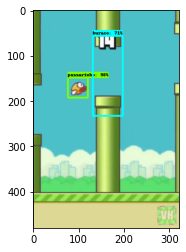

In [17]:
label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    max_score = np.max(detections['detection_scores'][0].numpy())
    max_box_index = np.argmax(detections['detection_scores'][0].numpy())
    print(detections['detection_boxes'][0].numpy()[max_box_index], max_score)
    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i).zfill(3) + ".jpg")

In [18]:
imageio.plugins.freeimage.download()

anim_file = 'bird.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps = 5)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)3964928/4830080 bytes (82.1%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [19]:
from google.colab import files
files.download("/content/{}".format(anim_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>